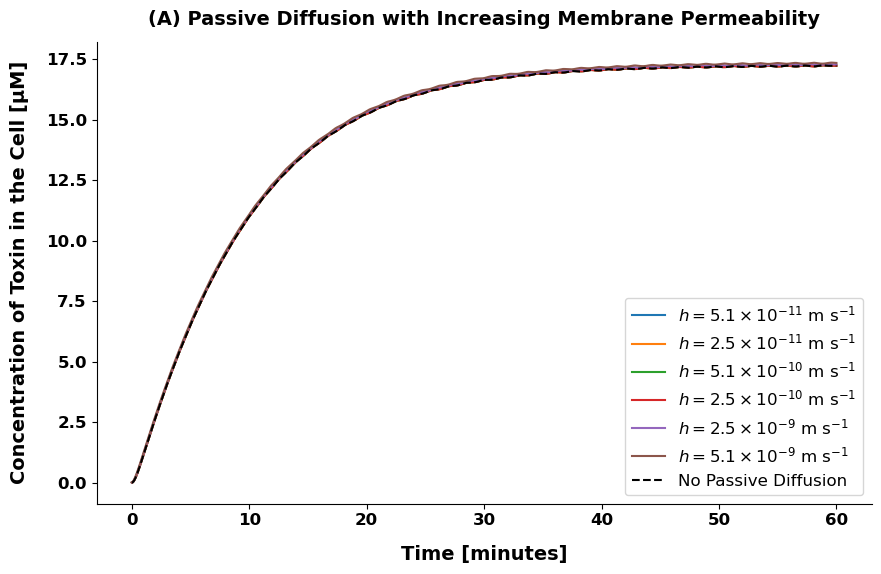

In [23]:
# EXPERIMENTAL MODEL
# Including passive diffusion with increasing membrane permeability 

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

# Default parameters and constants
V_Cell_Monolayer = 3.2e-07
V_Mem = 0.0032
V_Well = 0.0001

initial_OAT1 = 0.190962
initial_PCS_C = 0
initial_PCS_OAT1 = 0
Km_Efflux = 69
KMOLE = 0.00166054
Kr_Uptake = 0.000
Kr_dissociation = 0.000
Vmax_Efflux = 1.0e-05 * 23418 * KMOLE

initial_PCS_B = 100
Kf_Uptake = 1.44e-5
Kf_dissociation = 5.78e-04

h = 5.1e-11

# Parameters for the model
params = [Kf_Uptake, Kr_Uptake, Kf_dissociation, Kr_dissociation, Vmax_Efflux, Km_Efflux, V_Mem, V_Well, V_Cell_Monolayer, h]

# Define the model with passive diffusion
def model_with_diffusion(t, y, params):
    PCS_B, OAT1, PCS_OAT1, PCS_C = y
    Kf_Uptake, Kr_Uptake, Kf_dissociation, Kr_dissociation, Vmax_Efflux, Km_Efflux, V_Mem, V_Well, V_Cell_Monolayer, h = params

    J_diffusion = h * (PCS_B - PCS_C)
  
    dPCS_Bdt = (-((Kf_Uptake * OAT1 * PCS_B + (-Kr_Uptake * PCS_OAT1)) * V_Mem) +
               ((Vmax_Efflux * PCS_C) / (Km_Efflux + PCS_C) - J_diffusion) * V_Mem) / V_Well
 
    dOAT1dt = (-((Kf_Uptake * OAT1 * PCS_B + (-Kr_Uptake * PCS_OAT1)) * V_Mem) +
               ((Kf_dissociation * PCS_OAT1 + (-Kr_dissociation * OAT1 * PCS_C)) * V_Mem)) / V_Mem
 
    dPCS_OAT1dt = (((Kf_Uptake * OAT1 * PCS_B + (-Kr_Uptake * PCS_OAT1)) * V_Mem) -
                   ((Kf_dissociation * PCS_OAT1 + (-Kr_dissociation * OAT1 * PCS_C)) * V_Mem)) / V_Mem
    
    dPCS_Cdt = ((-(Vmax_Efflux * PCS_C) / (Km_Efflux + PCS_C) * V_Mem) +
               ((Kf_dissociation * PCS_OAT1 + (-Kr_dissociation * OAT1 * PCS_C) + J_diffusion) * V_Mem)) / V_Cell_Monolayer
 
    return [dPCS_Bdt, dOAT1dt, dPCS_OAT1dt, dPCS_Cdt]

# Define the model without passive diffusion
def model_no_diffusion(t, y, params_no_h):
    PCS_B, OAT1, PCS_OAT1, PCS_C = y
    Kf_Uptake, Kr_Uptake, Kf_dissociation, Kr_dissociation, Vmax_Efflux, Km_Efflux, V_Mem, V_Well, V_Cell_Monolayer = params_no_h

    dPCS_Bdt = (-((Kf_Uptake * OAT1 * PCS_B + (-Kr_Uptake * PCS_OAT1)) * V_Mem) +
               ( (Vmax_Efflux * PCS_C) / (Km_Efflux + PCS_C) ) * V_Mem) / V_Well
 
    dOAT1dt = (-((Kf_Uptake * OAT1 * PCS_B + (-Kr_Uptake * PCS_OAT1)) * V_Mem) +
               ((Kf_dissociation * PCS_OAT1 + (-Kr_dissociation * OAT1 * PCS_C)) * V_Mem)) / V_Mem
 
    dPCS_OAT1dt = (((Kf_Uptake * OAT1 * PCS_B + (-Kr_Uptake * PCS_OAT1)) * V_Mem) -
                   ((Kf_dissociation * PCS_OAT1 + (-Kr_dissociation * OAT1 * PCS_C)) * V_Mem)) / V_Mem
    
    dPCS_Cdt = ((-(Vmax_Efflux * PCS_C) / (Km_Efflux + PCS_C) * V_Mem) +
               ((Kf_dissociation * PCS_OAT1 + (-Kr_dissociation * OAT1 * PCS_C)) * V_Mem)) / V_Cell_Monolayer
 
    return [dPCS_Bdt, dOAT1dt, dPCS_OAT1dt, dPCS_Cdt]

# Time range for the simulation
t_span = [0, 3600]  # or simulate for 1 hour (3600 seconds)
t_eval = np.linspace(t_span[0], t_span[1], 3600)  # Time points where the solution will be evaluated

# Initial conditions for the state variables
y0 = [initial_PCS_B, initial_OAT1, initial_PCS_OAT1, initial_PCS_C]

# Range of h values to test (with passive diffusion)
h_values = [5.1e-11, 2.5e-11, 5.1e-10, 2.5e-10, 2.5e-9, 5.1e-9] 
    
plt.figure(figsize=(10, 6))

# Loop over each h value and run the simulation with passive diffusion
for h in h_values:
    # Update the h value in the parameters (replace the last element which is h)
    params_h = params[:-1] + [h]  # Replace the h value in params with the current h

    # Solve the ODE system using the model with diffusion
    solution_with_diffusion = solve_ivp(model_with_diffusion, t_span, y0, args=(params_h,), t_eval=t_eval)
    
    # Convert h value to \( 10^x \) notation for the legend
    exponent = int(np.floor(np.log10(h)))  # Extract the exponent
    coefficient = h / 10**exponent         # Extract the coefficient (mantissa)
    h_label = f"$h = {coefficient:.1f} \\times 10^{{{exponent}}}$ m s$^{{-1}}$"  # Format as \( 10^x \)
    
    # Plot PCS_C concentration over time for this value of h
    plt.plot(
        solution_with_diffusion.t / 60,  # Time in minutes
        solution_with_diffusion.y[3], 
        label=h_label

    )

# Solve the ODE system for no passive diffusion
params_no_h = params[:-1]  # Exclude h from params
solution_no_diffusion = solve_ivp(model_no_diffusion, t_span, y0, args=(params_no_h,), t_eval=t_eval)

# Plot the "no passive diffusion" line
plt.plot(
    solution_no_diffusion.t / 60,  # Time in minutes
    solution_no_diffusion.y[3], 
    label='No Passive Diffusion', 
    color='black', linestyle='--'
)

# Finalize the plot
plt.xlabel('Time [minutes]', fontsize=14, fontweight='bold', labelpad=12)
plt.ylabel('Concentration of Toxin in the Cell [µM]', fontsize=14, fontweight='bold', labelpad=12)
plt.legend(fontsize=12, loc='lower right')
plt.title('(A) Passive Diffusion with Increasing Membrane Permeability', fontsize=14, fontweight='bold', pad=12)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
plt.savefig('R_Pass_D.png', dpi=300)
plt.show()


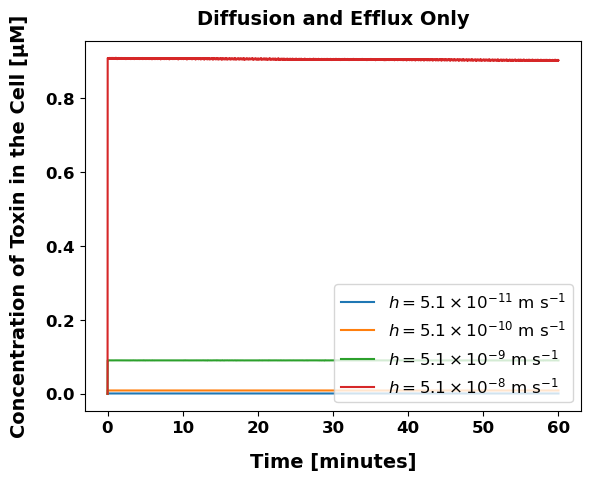

In [24]:
# Define the model with only passive diffusion and efflux
def model_diffusion_efflux_only(t, y, params):
    PCS_B, OAT1, PCS_OAT1, PCS_C = y
    # Extract relevant parameters
    Kf_Uptake, Kr_Uptake, Kf_dissociation, Kr_dissociation, Vmax_Efflux, Km_Efflux, V_Mem, V_Well, V_Cell_Monolayer, h = params
    
    # Passive diffusion flux
    J_diffusion = h * (PCS_B - PCS_C)
    
    # Differential equations (consider only diffusion and efflux)
    dPCS_Bdt = (-J_diffusion * V_Mem) / V_Well  # Bulk concentration change
    dPCS_Cdt = ((-Vmax_Efflux * PCS_C) / (Km_Efflux + PCS_C) + J_diffusion) / V_Cell_Monolayer  # Intracellular concentration
    
    # No changes in OAT1 and PCS_OAT1 since uptake and dissociation are zero
    dOAT1dt = 0
    dPCS_OAT1dt = 0
    
    return [dPCS_Bdt, dOAT1dt, dPCS_OAT1dt, dPCS_Cdt]

h_values = [5.1e-11, 5.1e-10, 5.1e-9, 5.1e-8] 

# Parameters for the simulation
params_diffusion_efflux = [0, 0, 0, 0, Vmax_Efflux, Km_Efflux, V_Mem, V_Well, V_Cell_Monolayer, 0]  # Kf, Kr set to 0

# Loop over each h value and run the simulation with only diffusion and efflux
for h in h_values:
    # Update the h value in the parameters
    params_diffusion_efflux[-1] = h  # Update the h value
    
    # Solve the ODE system
    solution_diffusion_efflux = solve_ivp(model_diffusion_efflux_only, t_span, y0, args=(params_diffusion_efflux,), t_eval=t_eval)
    
    # Extract the exponent from the h value for annotation
    exponent = int(np.log10(h / 5.1))  # Compute the exponent of h relative to 5.1
    
    # Plot PCS_C concentration over time for this value of h
    plt.plot(
        solution_diffusion_efflux.t / 60,  # Time in minutes
        solution_diffusion_efflux.y[3], 
        label=f'$h = 5.1 \\times 10^{{{exponent}}}$ m s$^{{-1}}$'
    )

# Finalize the plot
plt.xlabel('Time [minutes]', fontsize=14, fontweight='bold', labelpad=12)
plt.ylabel('Concentration of Toxin in the Cell [µM]', fontsize=14, fontweight='bold', labelpad=12)
plt.legend(fontsize=12, loc='lower right')
plt.title('Diffusion and Efflux Only', fontsize=14, fontweight='bold', pad=12)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.savefig('Diffusion_Efflux_Only.png')
plt.show()


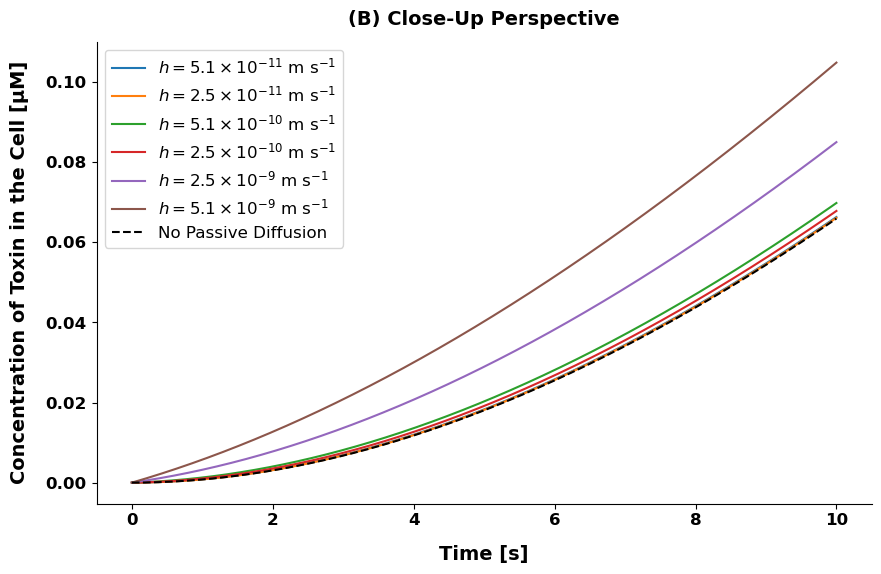

In [25]:
# Time range for the simulation
t_span = [0, 10]  # or simulate for 1 hour (3600 seconds)
t_eval = np.linspace(t_span[0], t_span[1], 5000)  # Time points where the solution will be evaluated

# Range of h values to test (with passive diffusion)
h_values = [5.1e-11, 2.5e-11, 5.1e-10, 2.5e-10, 2.5e-9, 5.1e-9] 
    
plt.figure(figsize=(10, 6))

# Loop over each h value and run the simulation with passive diffusion
for h in h_values:
    # Update the h value in the parameters (replace the last element which is h)
    params_h = params[:-1] + [h]  # Replace the h value in params with the current h

    # Solve the ODE system using the model with diffusion
    solution_with_diffusion = solve_ivp(model_with_diffusion, t_span, y0, args=(params_h,), t_eval=t_eval)
    
    # Convert h value to \( 10^x \) notation for the legend
    exponent = int(np.floor(np.log10(h)))  # Extract the exponent
    coefficient = h / 10**exponent         # Extract the coefficient (mantissa)
    h_label = f"$h = {coefficient:.1f} \\times 10^{{{exponent}}}$ m s$^{{-1}}$"  # Format as \( 10^x \)
    
    # Plot PCS_C concentration over time for this value of h
    plt.plot(
        solution_with_diffusion.t,  # Time in minutes
        solution_with_diffusion.y[3], 
        label=h_label

    )

# Solve the ODE system for no passive diffusion
params_no_h = params[:-1]  # Exclude h from params
solution_no_diffusion = solve_ivp(model_no_diffusion, t_span, y0, args=(params_no_h,), t_eval=t_eval)

# Plot the "no passive diffusion" line
plt.plot(
    solution_no_diffusion.t,  # Time in minutes
    solution_no_diffusion.y[3], 
    label='No Passive Diffusion', 
    color='black', linestyle='--'
)

# Finalize the plot
plt.xlabel('Time [s]', fontsize=14, fontweight='bold', labelpad=12)
plt.ylabel('Concentration of Toxin in the Cell [µM]', fontsize=14, fontweight='bold', labelpad=12)
plt.legend(fontsize=12, loc='upper left')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title('(B) Close-Up Perspective', fontsize=14, fontweight='bold', pad=12)
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
plt.savefig('R_PassD_Zoom.png', dpi=300)
plt.show()